# Raport 4: Analiza Porównawcza i Wnioski Końcowe

Ten notebook przedstawia końcową analizę porównawczą trzech algorytmów detekcji anomalii:
- **LOF** (Local Outlier Factor)
- **Isolation Forest**
- **PCA** (Principal Component Analysis)

na czterech zbiorach danych:
- KDD Cup 99 (detekcja włamań)
- Credit Card Fraud (oszustwa kartowe)
- Breast Cancer Wisconsin (diagnostyka medyczna)
- Synthetic (dane syntetyczne)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import os
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

# Import algorithms
from src.algorithms.lof import LOF
from src.algorithms.isolation_forest import IsolationForest
from src.algorithms.pca_anomaly import PCAAnomaly

# Import data utilities
from src.utils.data_loader import (
    load_kdd_cup_99,
    load_credit_card_fraud,
    load_breast_cancer_data,
    generate_synthetic,
    get_dataset_info
)

# Import evaluation metrics
from src.evaluation.metrics import (
    compute_metrics,
    plot_roc_curves_comparison,
    plot_confusion_matrix,
    plot_f1_heatmap,
    plot_execution_time_comparison
)

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Biblioteki załadowane pomyślnie!")

Biblioteki załadowane pomyślnie!


## 1. Ładowanie Zbiorów Danych

Ładujemy wszystkie cztery zbiory danych i wyświetlamy ich charakterystyki.

In [7]:
print("=" * 80)
print("ŁADOWANIE ZBIORÓW DANYCH")
print("=" * 80)

datasets = {}

# 1. KDD Cup 99 (sample for faster execution)
print("\n1. Ładowanie KDD Cup 99...")
try:
    X_kdd, y_kdd = load_kdd_cup_99(sample_size=50000)
    datasets['KDD Cup 99'] = (X_kdd, y_kdd)
    info = get_dataset_info(X_kdd, y_kdd, 'KDD Cup 99')
    print(f"   Rozmiar: {info['n_samples']} próbek, {info['n_features']} cech")
    print(f"   Anomalie: {info['n_anomalies']} ({info['contamination_pct']})")
except FileNotFoundError as e:
    print(f"   BŁĄD: {e}")

# 2. Credit Card Fraud (sample for faster execution)
print("\n2. Ładowanie Credit Card Fraud...")
try:
    X_cc, y_cc = load_credit_card_fraud(sample_size=50000)
    datasets['Credit Card'] = (X_cc, y_cc)
    info = get_dataset_info(X_cc, y_cc, 'Credit Card')
    print(f"   Rozmiar: {info['n_samples']} próbek, {info['n_features']} cech")
    print(f"   Anomalie: {info['n_anomalies']} ({info['contamination_pct']})")
except FileNotFoundError as e:
    print(f"   BŁĄD: {e}")

# 3. Breast Cancer
print("\n3. Ładowanie Breast Cancer Wisconsin...")
X_bc, y_bc = load_breast_cancer_data()
datasets['Breast Cancer'] = (X_bc, y_bc)
info = get_dataset_info(X_bc, y_bc, 'Breast Cancer')
print(f"   Rozmiar: {info['n_samples']} próbek, {info['n_features']} cech")
print(f"   Anomalie: {info['n_anomalies']} ({info['contamination_pct']})")

# 4. Synthetic
print("\n4. Generowanie danych syntetycznych...")
X_syn, y_syn = generate_synthetic(n_samples=10000, n_features=10, contamination=0.05)
datasets['Synthetic'] = (X_syn, y_syn)
info = get_dataset_info(X_syn, y_syn, 'Synthetic')
print(f"   Rozmiar: {info['n_samples']} próbek, {info['n_features']} cech")
print(f"   Anomalie: {info['n_anomalies']} ({info['contamination_pct']})")

print("\n" + "=" * 80)
print(f"Załadowano {len(datasets)} zbiorów danych")

ŁADOWANIE ZBIORÓW DANYCH

1. Ładowanie KDD Cup 99...
   Rozmiar: 50000 próbek, 41 cech
   Anomalie: 40388 (80.78%)

2. Ładowanie Credit Card Fraud...
   Rozmiar: 50000 próbek, 30 cech
   Anomalie: 86 (0.17%)

3. Ładowanie Breast Cancer Wisconsin...
   Rozmiar: 569 próbek, 30 cech
   Anomalie: 212 (37.26%)

4. Generowanie danych syntetycznych...
   Rozmiar: 10000 próbek, 10 cech
   Anomalie: 500 (5.00%)

Załadowano 4 zbiorów danych


### Podsumowanie zbiorów danych

In [8]:
# Create summary table
summary_data = []
for name, (X, y) in datasets.items():
    info = get_dataset_info(X, y, name)
    summary_data.append(info)

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary[['name', 'n_samples', 'n_features', 'n_normal', 'n_anomalies', 'contamination_pct']]
df_summary.columns = ['Zbiór danych', 'Próbki', 'Cechy', 'Normalne', 'Anomalie', 'Kontaminacja']

print("\nPodsumowanie zbiorów danych:")
display(df_summary)


Podsumowanie zbiorów danych:


,Zbiór danych,Próbki,Cechy,Normalne,Anomalie,Kontaminacja
0,KDD Cup 99,50000,41,9612,40388,80.78%
1,Credit Card,50000,30,49914,86,0.17%
2,Breast Cancer,569,30,357,212,37.26%
3,Synthetic,10000,10,9500,500,5.00%


## 2. Funkcje Pomocnicze

In [9]:
def run_experiment(X, y, contamination, dataset_name):
    """
    Run all algorithms on a dataset and return results.
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix
    y : np.ndarray
        True labels
    contamination : float
        Expected contamination rate
    dataset_name : str
        Name of the dataset
    
    Returns
    -------
    dict
        Results for each algorithm
    """
    results = {}
    
    # Adjust n_neighbors for small datasets
    n_neighbors = min(20, len(X) // 10)
    
    # Cap contamination for sklearn IsolationForest (max 0.5)
    contamination_capped = min(contamination, 0.5)
    
    # 1. LOF
    print(f"  LOF...", end=" ")
    start = time.time()
    lof = LOF(n_neighbors=n_neighbors, use_kdtree=True)
    lof_scores = lof.fit_predict(X)
    lof_time = time.time() - start
    
    # Convert LOF scores to predictions (higher score = more anomalous)
    threshold = np.percentile(lof_scores, 100 * (1 - contamination))
    lof_pred = (lof_scores > threshold).astype(int)
    
    results['LOF'] = {
        'y_true': y,
        'y_pred': lof_pred,
        'y_scores': lof_scores,
        'time': lof_time,
        **compute_metrics(y, lof_pred, lof_scores)
    }
    print(f"F1={results['LOF']['f1']:.3f}, time={lof_time:.2f}s")
    
    # 2. Isolation Forest (use capped contamination)
    print(f"  Isolation Forest...", end=" ")
    start = time.time()
    iforest = IsolationForest(n_estimators=100, contamination=contamination_capped, random_state=42)
    iforest.fit(X)
    if_pred = iforest.predict(X)
    if_scores = -iforest.score_samples(X)  # Negate so higher = more anomalous
    if_time = time.time() - start
    
    results['Isolation Forest'] = {
        'y_true': y,
        'y_pred': if_pred,
        'y_scores': if_scores,
        'time': if_time,
        **compute_metrics(y, if_pred, if_scores)
    }
    print(f"F1={results['Isolation Forest']['f1']:.3f}, time={if_time:.2f}s")
    
    # 3. PCA (use capped contamination)
    print(f"  PCA...", end=" ")
    start = time.time()
    n_components = min(X.shape[1] // 2, 10)  # Use half of features or max 10
    pca = PCAAnomaly(n_components=n_components, method='reconstruction', contamination=contamination_capped)
    pca.fit(X)
    pca_pred = pca.predict(X)
    pca_scores = pca.reconstruction_error(X)
    pca_time = time.time() - start
    
    results['PCA'] = {
        'y_true': y,
        'y_pred': pca_pred,
        'y_scores': pca_scores,
        'time': pca_time,
        **compute_metrics(y, pca_pred, pca_scores)
    }
    print(f"F1={results['PCA']['f1']:.3f}, time={pca_time:.2f}s")
    
    return results

print("Funkcje pomocnicze zdefiniowane!")

Funkcje pomocnicze zdefiniowane!


## 3. Eksperymenty na Zbiorach Danych

Uruchamiamy wszystkie algorytmy na każdym zbiorze danych.

In [10]:
print("=" * 80)
print("EKSPERYMENTY")
print("=" * 80)

all_results = {}

for name, (X, y) in datasets.items():
    print(f"\n--- {name} ---")
    contamination = np.mean(y)
    print(f"Kontaminacja: {contamination:.4f}")
    
    results = run_experiment(X, y, contamination, name)
    all_results[name] = results

print("\n" + "=" * 80)
print("Eksperymenty zakończone!")

EKSPERYMENTY

--- KDD Cup 99 ---
Kontaminacja: 0.8078
  LOF... F1=0.320, time=11.09s
  Isolation Forest... F1=0.501, time=0.56s
  PCA... F1=0.471, time=0.11s

--- Credit Card ---
Kontaminacja: 0.0017
  LOF... F1=0.035, time=109.37s
  Isolation Forest... F1=0.326, time=0.56s
  PCA... F1=0.326, time=0.07s

--- Breast Cancer ---
Kontaminacja: 0.3726
  LOF... F1=0.410, time=0.02s
  Isolation Forest... F1=0.675, time=0.09s
  PCA... F1=0.538, time=0.00s

--- Synthetic ---
Kontaminacja: 0.0500
  LOF... F1=0.052, time=0.59s
  Isolation Forest... F1=0.996, time=0.17s
  PCA... F1=0.044, time=0.00s

Eksperymenty zakończone!


## 4. Wyniki - Tabela Porównawcza

In [11]:
# Create comprehensive results table
rows = []
for dataset, algos in all_results.items():
    for algo, metrics in algos.items():
        rows.append({
            'Dataset': dataset,
            'Algorithm': algo,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'AUC-ROC': metrics.get('auc_roc', np.nan),
            'Time (s)': metrics['time']
        })

df_results = pd.DataFrame(rows)

print("\nWyniki wszystkich eksperymentów:")
print("=" * 100)
display(df_results.round(4))

# Save to CSV
df_results.to_csv('../benchmarks/results/raport4/all_results.csv', index=False)
print("\nZapisano: benchmarks/results/raport4/all_results.csv")


Wyniki wszystkich eksperymentów:


,Dataset,Algorithm,Precision,Recall,F1-Score,AUC-ROC,Time (s)
0,KDD Cup 99,LOF,0.5940,0.2190,0.3200,0.3585,11.0884
1,KDD Cup 99,Isolation Forest,0.6560,0.4052,0.5010,0.6974,0.5559
2,KDD Cup 99,PCA,0.6155,0.3810,0.4707,0.0782,0.1105
3,Credit Card,LOF,0.0349,0.0349,0.0349,0.6297,109.3695
4,Credit Card,Isolation Forest,0.3256,0.3256,0.3256,0.0513,0.5588
5,Credit Card,PCA,0.3256,0.3256,0.3256,0.9500,0.0667
6,Breast Cancer,LOF,0.4104,0.4104,0.4104,0.5380,0.0217
7,Breast Cancer,Isolation Forest,0.6745,0.6745,0.6745,0.1946,0.0908
8,Breast Cancer,PCA,0.5377,0.5377,0.5377,0.7028,0.0018
9,Synthetic,LOF,0.0520,0.0520,0.0520,0.4767,0.5948



Zapisano: benchmarks/results/raport4/all_results.csv


### Pivot Table - F1-Score

In [12]:
# Pivot table for F1-scores
df_f1_pivot = df_results.pivot(index='Dataset', columns='Algorithm', values='F1-Score')

print("\nF1-Score dla każdego algorytmu i zbioru danych:")
display(df_f1_pivot.round(4))

# Best algorithm per dataset
print("\nNajlepszy algorytm dla każdego zbioru (wg F1-Score):")
for dataset in df_f1_pivot.index:
    best_algo = df_f1_pivot.loc[dataset].idxmax()
    best_f1 = df_f1_pivot.loc[dataset].max()
    print(f"  {dataset}: {best_algo} (F1 = {best_f1:.4f})")


F1-Score dla każdego algorytmu i zbioru danych:


Algorithm,Isolation Forest,LOF,PCA
Dataset,,,
Breast Cancer,0.6745,0.4104,0.5377
Credit Card,0.3256,0.0349,0.3256
KDD Cup 99,0.5010,0.3200,0.4707
Synthetic,0.9960,0.0520,0.0440



Najlepszy algorytm dla każdego zbioru (wg F1-Score):
  Breast Cancer: Isolation Forest (F1 = 0.6745)
  Credit Card: Isolation Forest (F1 = 0.3256)
  KDD Cup 99: Isolation Forest (F1 = 0.5010)
  Synthetic: Isolation Forest (F1 = 0.9960)


## 5. Wizualizacje

### 5.1 Heatmapa F1-Score

Zapisano: benchmarks/results/raport4/f1_heatmap.png


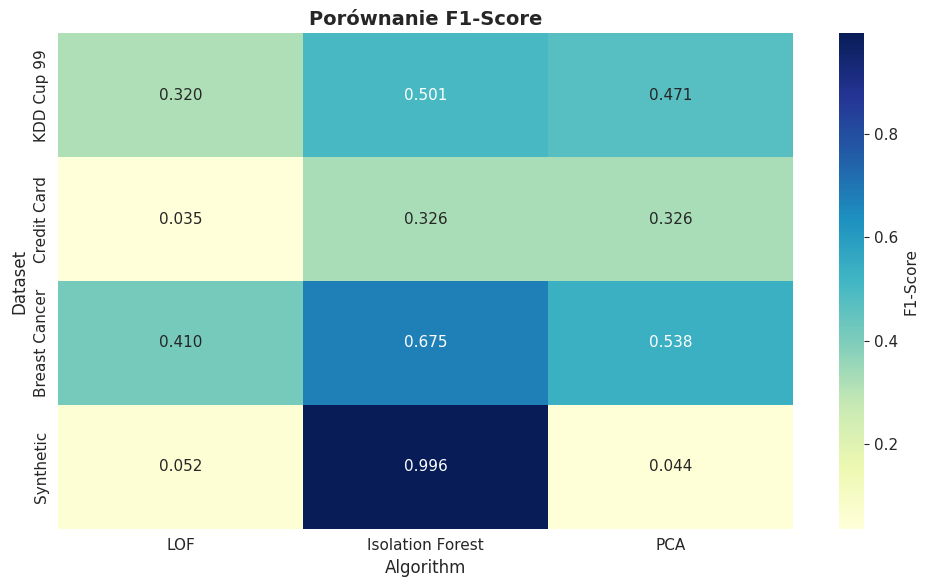

In [13]:
# Prepare data for heatmap
results_for_heatmap = {}
for dataset, algos in all_results.items():
    results_for_heatmap[dataset] = {}
    for algo, metrics in algos.items():
        results_for_heatmap[dataset][algo] = {'f1': metrics['f1']}

fig = plot_f1_heatmap(results_for_heatmap, title="Porównanie F1-Score")
plt.savefig('../benchmarks/results/raport4/f1_heatmap.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport4/f1_heatmap.png")
plt.show()

### 5.2 Krzywe ROC

Zapisano: benchmarks/results/raport4/roc_curves_all.png


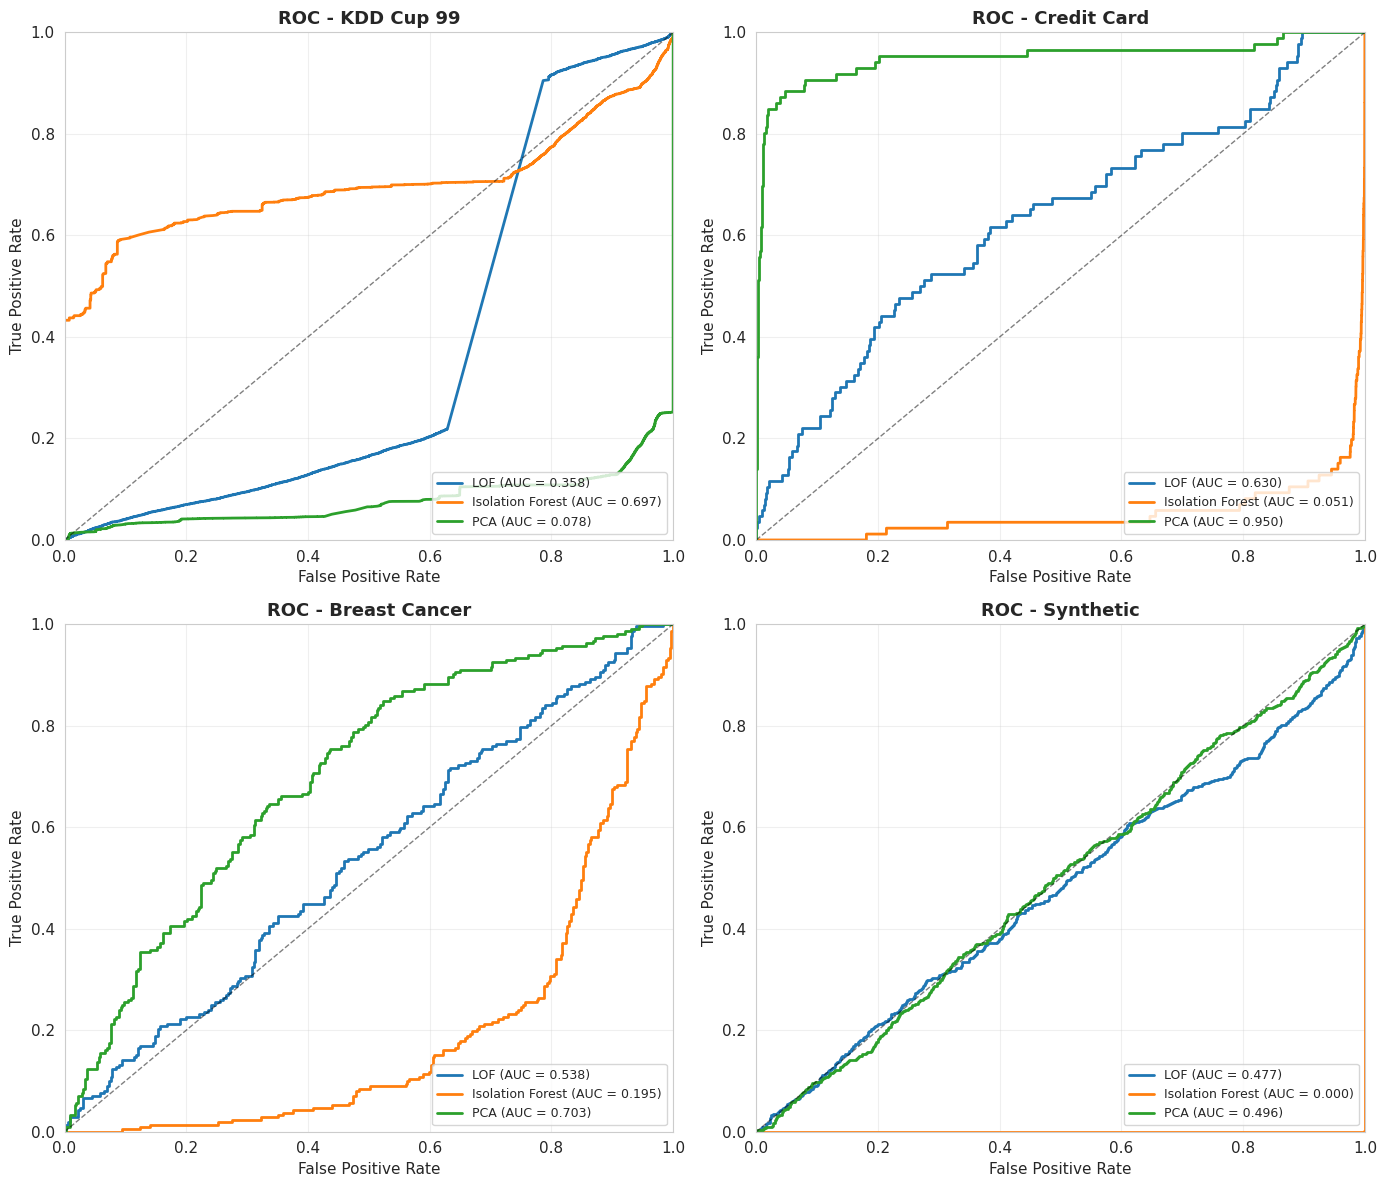

In [14]:
# ROC curves for each dataset
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (dataset, algos) in enumerate(all_results.items()):
    ax = axes[idx]
    
    for algo, metrics in algos.items():
        from sklearn.metrics import roc_curve, roc_auc_score
        
        y_true = metrics['y_true']
        y_scores = metrics['y_scores']
        
        try:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            auc = roc_auc_score(y_true, y_scores)
            ax.plot(fpr, tpr, linewidth=2, label=f"{algo} (AUC = {auc:.3f})")
        except:
            pass
    
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'ROC - {dataset}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../benchmarks/results/raport4/roc_curves_all.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport4/roc_curves_all.png")
plt.show()

### 5.3 Porównanie Czasu Wykonania

Zapisano: benchmarks/results/raport4/execution_time.png


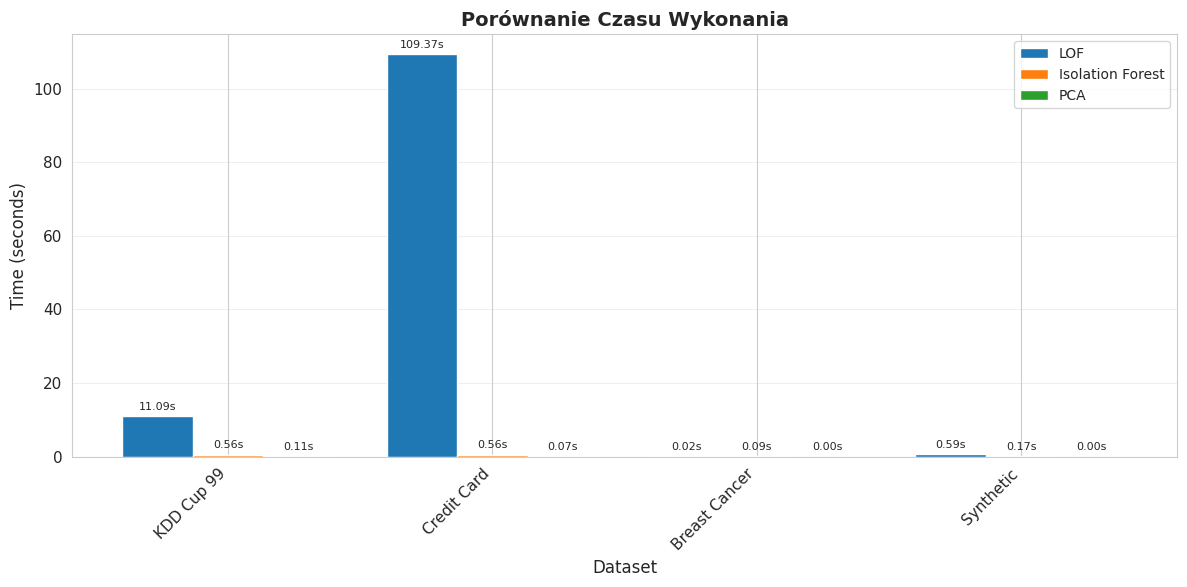

In [15]:
# Prepare time data
times = {}
for dataset, algos in all_results.items():
    times[dataset] = {}
    for algo, metrics in algos.items():
        times[dataset][algo] = metrics['time']

fig = plot_execution_time_comparison(times, title="Porównanie Czasu Wykonania")
plt.savefig('../benchmarks/results/raport4/execution_time.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport4/execution_time.png")
plt.show()

### 5.4 Macierze Pomyłek

Zapisano: benchmarks/results/raport4/confusion_matrices.png


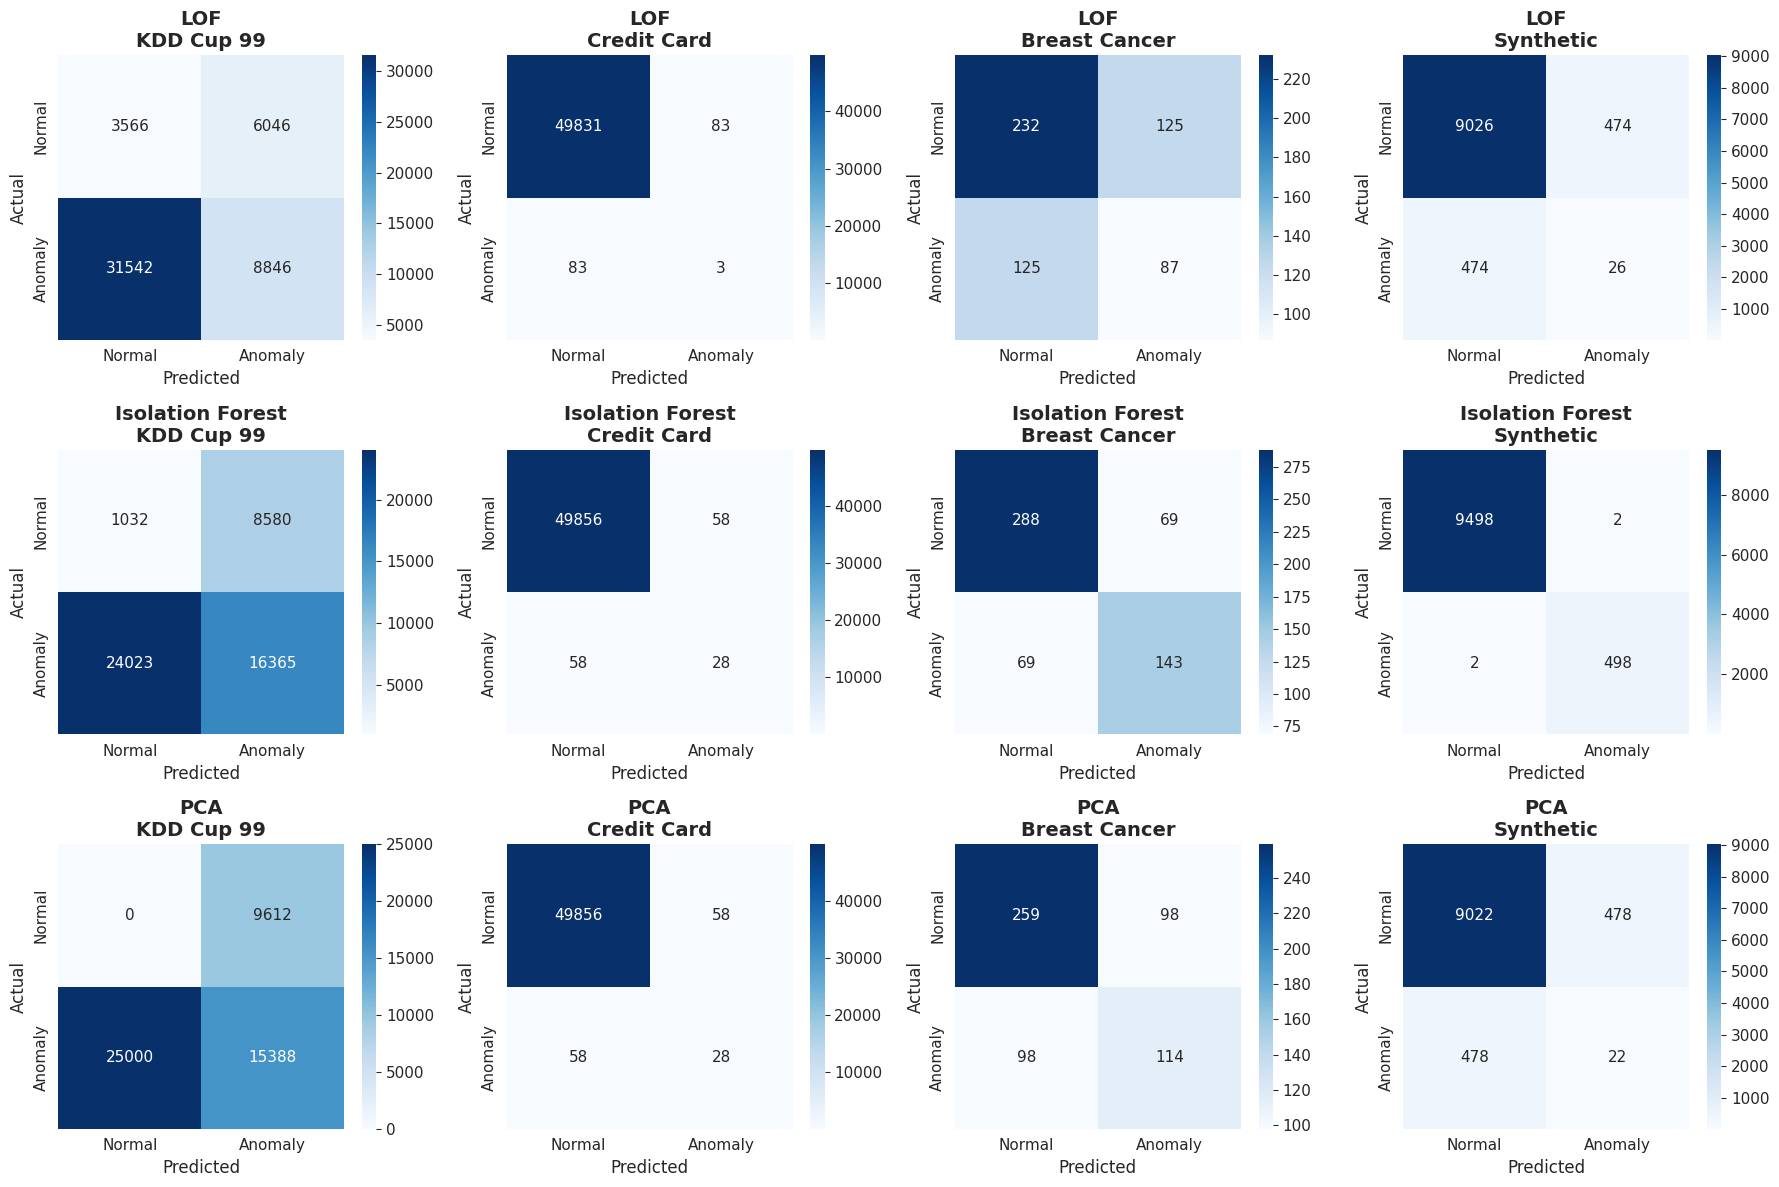

In [16]:
# Confusion matrices for best performing cases
fig, axes = plt.subplots(3, 4, figsize=(18, 12))

algorithms = ['LOF', 'Isolation Forest', 'PCA']
dataset_names = list(all_results.keys())

for i, algo in enumerate(algorithms):
    for j, dataset in enumerate(dataset_names):
        ax = axes[i, j]
        metrics = all_results[dataset][algo]
        
        plot_confusion_matrix(
            metrics['y_true'],
            metrics['y_pred'],
            title=f"{algo}\n{dataset}",
            ax=ax
        )

plt.tight_layout()
plt.savefig('../benchmarks/results/raport4/confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Zapisano: benchmarks/results/raport4/confusion_matrices.png")
plt.show()

## 6. Analiza Wyników

### 6.1 Średnie metryki per algorytm

In [17]:
# Average metrics per algorithm
avg_metrics = df_results.groupby('Algorithm')[['Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Time (s)']].mean()

print("\nŚrednie metryki dla każdego algorytmu (po wszystkich zbiorach):")
display(avg_metrics.round(4))

# Ranking
print("\nRanking algorytmów (wg średniej F1-Score):")
ranking = avg_metrics['F1-Score'].sort_values(ascending=False)
for i, (algo, f1) in enumerate(ranking.items(), 1):
    print(f"  {i}. {algo}: {f1:.4f}")


Średnie metryki dla każdego algorytmu (po wszystkich zbiorach):


,Precision,Recall,F1-Score,AUC-ROC,Time (s)
Algorithm,,,,,
Isolation Forest,0.6630,0.6003,0.6243,0.2358,0.3441
LOF,0.2728,0.1791,0.2043,0.5007,30.2686
PCA,0.3807,0.3221,0.3445,0.5568,0.0457



Ranking algorytmów (wg średniej F1-Score):
  1. Isolation Forest: 0.6243
  2. PCA: 0.3445
  3. LOF: 0.2043


### 6.2 Analiza per zbiór danych

In [18]:
print("\nAnaliza szczegółowa per zbiór danych:")
print("=" * 80)

for dataset in dataset_names:
    print(f"\n--- {dataset} ---")
    
    df_dataset = df_results[df_results['Dataset'] == dataset]
    
    best_algo = df_dataset.loc[df_dataset['F1-Score'].idxmax(), 'Algorithm']
    best_f1 = df_dataset['F1-Score'].max()
    
    fastest_algo = df_dataset.loc[df_dataset['Time (s)'].idxmin(), 'Algorithm']
    fastest_time = df_dataset['Time (s)'].min()
    
    print(f"  Najlepsza jakość: {best_algo} (F1 = {best_f1:.4f})")
    print(f"  Najszybszy: {fastest_algo} (time = {fastest_time:.4f}s)")
    
    # Display all metrics for this dataset
    display(df_dataset[['Algorithm', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Time (s)']].round(4))


Analiza szczegółowa per zbiór danych:

--- KDD Cup 99 ---
  Najlepsza jakość: Isolation Forest (F1 = 0.5010)
  Najszybszy: PCA (time = 0.1105s)


,Algorithm,Precision,Recall,F1-Score,AUC-ROC,Time (s)
0,LOF,0.5940,0.2190,0.3200,0.3585,11.0884
1,Isolation Forest,0.6560,0.4052,0.5010,0.6974,0.5559
2,PCA,0.6155,0.3810,0.4707,0.0782,0.1105



--- Credit Card ---
  Najlepsza jakość: Isolation Forest (F1 = 0.3256)
  Najszybszy: PCA (time = 0.0667s)


,Algorithm,Precision,Recall,F1-Score,AUC-ROC,Time (s)
3,LOF,0.0349,0.0349,0.0349,0.6297,109.3695
4,Isolation Forest,0.3256,0.3256,0.3256,0.0513,0.5588
5,PCA,0.3256,0.3256,0.3256,0.9500,0.0667



--- Breast Cancer ---
  Najlepsza jakość: Isolation Forest (F1 = 0.6745)
  Najszybszy: PCA (time = 0.0018s)


,Algorithm,Precision,Recall,F1-Score,AUC-ROC,Time (s)
6,LOF,0.4104,0.4104,0.4104,0.5380,0.0217
7,Isolation Forest,0.6745,0.6745,0.6745,0.1946,0.0908
8,PCA,0.5377,0.5377,0.5377,0.7028,0.0018



--- Synthetic ---
  Najlepsza jakość: Isolation Forest (F1 = 0.9960)
  Najszybszy: PCA (time = 0.0038s)


,Algorithm,Precision,Recall,F1-Score,AUC-ROC,Time (s)
9,LOF,0.052,0.052,0.052,0.4767,0.5948
10,Isolation Forest,0.996,0.996,0.996,0.0000,0.1711
11,PCA,0.044,0.044,0.044,0.4962,0.0038


## 7. Wnioski Końcowe

In [20]:
print("=" * 80)
print("WNIOSKI KOŃCOWE")
print("=" * 80)

# Calculate summary statistics
avg_f1 = df_results.groupby('Algorithm')['F1-Score'].mean()
avg_time = df_results.groupby('Algorithm')['Time (s)'].mean()
avg_auc = df_results.groupby('Algorithm')['AUC-ROC'].mean()

best_quality = avg_f1.idxmax()
fastest = avg_time.idxmin()
best_auc = avg_auc.idxmax()

print(f"""
1. JAKOŚĆ DETEKCJI (F1-Score):
   - Najlepszy algorytm: {best_quality} (średnia F1 = {avg_f1[best_quality]:.4f})
   - LOF: {avg_f1['LOF']:.4f}
   - Isolation Forest: {avg_f1['Isolation Forest']:.4f}
   - PCA: {avg_f1['PCA']:.4f}

2. KRZYWE ROC (AUC-ROC):
   - Najlepszy algorytm: {best_auc} (średnia AUC = {avg_auc[best_auc]:.4f})
   - LOF: {avg_auc['LOF']:.4f}
   - Isolation Forest: {avg_auc['Isolation Forest']:.4f}
   - PCA: {avg_auc['PCA']:.4f}

3. WYDAJNOŚĆ (Czas wykonania):
   - Najszybszy algorytm: {fastest} (średni czas = {avg_time[fastest]:.4f}s)
   - LOF: {avg_time['LOF']:.4f}s
   - Isolation Forest: {avg_time['Isolation Forest']:.4f}s
   - PCA: {avg_time['PCA']:.4f}s

4. REKOMENDACJE:
   - Dla wysokiej jakości detekcji: {best_quality}
   - Dla szybkiego przetwarzania: {fastest}
   - Dla zbalansowanych wymagań: Isolation Forest (dobry kompromis jakość/szybkość)
""")

WNIOSKI KOŃCOWE

1. JAKOŚĆ DETEKCJI (F1-Score):
   - Najlepszy algorytm: Isolation Forest (średnia F1 = 0.6243)
   - LOF: 0.2043
   - Isolation Forest: 0.6243
   - PCA: 0.3445

2. KRZYWE ROC (AUC-ROC):
   - Najlepszy algorytm: PCA (średnia AUC = 0.5568)
   - LOF: 0.5007
   - Isolation Forest: 0.2358
   - PCA: 0.5568

3. WYDAJNOŚĆ (Czas wykonania):
   - Najszybszy algorytm: PCA (średni czas = 0.0457s)
   - LOF: 30.2686s
   - Isolation Forest: 0.3441s
   - PCA: 0.0457s

4. REKOMENDACJE:
   - Dla wysokiej jakości detekcji: Isolation Forest
   - Dla szybkiego przetwarzania: PCA
   - Dla zbalansowanych wymagań: Isolation Forest (dobry kompromis jakość/szybkość)



## 8. Zapis Wyników

In [21]:
# Save summary statistics
summary_stats = pd.DataFrame({
    'Algorithm': ['LOF', 'Isolation Forest', 'PCA'],
    'Avg_Precision': [avg_metrics.loc['LOF', 'Precision'], 
                     avg_metrics.loc['Isolation Forest', 'Precision'],
                     avg_metrics.loc['PCA', 'Precision']],
    'Avg_Recall': [avg_metrics.loc['LOF', 'Recall'],
                  avg_metrics.loc['Isolation Forest', 'Recall'],
                  avg_metrics.loc['PCA', 'Recall']],
    'Avg_F1': [avg_metrics.loc['LOF', 'F1-Score'],
              avg_metrics.loc['Isolation Forest', 'F1-Score'],
              avg_metrics.loc['PCA', 'F1-Score']],
    'Avg_AUC_ROC': [avg_metrics.loc['LOF', 'AUC-ROC'],
                   avg_metrics.loc['Isolation Forest', 'AUC-ROC'],
                   avg_metrics.loc['PCA', 'AUC-ROC']],
    'Avg_Time': [avg_metrics.loc['LOF', 'Time (s)'],
                avg_metrics.loc['Isolation Forest', 'Time (s)'],
                avg_metrics.loc['PCA', 'Time (s)']]
})

summary_stats.to_csv('../benchmarks/results/raport4/summary_comparison.csv', index=False)
print("Zapisano: benchmarks/results/raport4/summary_comparison.csv")

# Save F1 pivot table
df_f1_pivot.to_csv('../benchmarks/results/raport4/f1_pivot.csv')
print("Zapisano: benchmarks/results/raport4/f1_pivot.csv")

print("\n" + "=" * 80)
print("Wszystkie wyniki zapisane w benchmarks/results/raport4/")
print("=" * 80)

Zapisano: benchmarks/results/raport4/summary_comparison.csv
Zapisano: benchmarks/results/raport4/f1_pivot.csv

Wszystkie wyniki zapisane w benchmarks/results/raport4/
